# Important Imports

In [2]:
import math
import numpy as np
import pandas as pd

# To split data
from sklearn.model_selection import train_test_split, cross_val_score

# To compute accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score

from sklearn import metrics
import matplotlib.pyplot as plt

# To scale data
from sklearn.preprocessing import MinMaxScaler

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# To load the data
#### &rarr; We specify that column 0 is the index column
#### &rarr;  We print the first 5 rows

In [4]:
dataFrame = pd.read_csv('data.csv', index_col=0)
dataFrame.head(5)

,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


# -----------------------------------------------------------------------------------------------

# KNN

# Preprocessing the data
* We first one-hot-encode the listed features as thet are considered categorical features (from location....diff_sys_hos)
* We pop column result from the dataframe, to insert it back again in the last column in the dataframe
* We store dataframe in numpy array

In [5]:
OneHotEncoded_knn = pd.get_dummies(dataFrame, columns=['location', 'country', 'gender',
                                                          'symptom1', 'symptom2', 'symptom3', 'symptom4', 'symptom5',
                                                          'symptom6', 'diff_sym_hos'])
# To make result column the last
result_popped_knn = OneHotEncoded_knn.pop('result')

OneHotEncoded_knn.insert(293, 'result', result_popped_knn)

Data_knn = np.array(OneHotEncoded_knn)


# Data[0]

# Splitting the data
* We split the data 80% training set and 10% validation set and 10% testing set
* We then split each set to x and y. 

   &rarr; X contains all the columns except column result 
   
   &rarr; Y is the column result

In [6]:
Train_set_knn, Remain_set_knn = train_test_split(Data_knn, train_size=0.8, random_state=30, shuffle=True)
Test_set_knn, Valid_set_knn = train_test_split(Remain_set_knn, test_size=0.5, random_state=30, shuffle=True)

xTrain_knn = Train_set_knn[:, :293]
yTrain_knn = Train_set_knn[:, 293]

xTest_knn = Test_set_knn[:, :293]
yTest_knn = Test_set_knn[:, 293]

xValid_knn = Valid_set_knn[:, :293]
yValid_knn = Valid_set_knn[:, 293]

# To get best k using for loop
&rarr; K represents number of neighbours (Number of points taken to know which class the new patient will belong to). The new data point is classified by the majority of votes from its k neighbours
* In each k in for loop *(from 0 to square root of the size of validation set)*:

  &rarr; We train the knn classifier with the training set
  
  &rarr; Then we predict the outcome by the validation set
  
  &rarr; Then we calculate the accuracy by recall_score, **as our output specifies whether the patient has Covid-19 or not, so    we are concerned more with the false negatives as it has more risk to specify that a patient has not Covid-19, but actually he   has. So the recall should be high**
  
  &rarr; Finally we choose the best k and print it

In [7]:
k = 0
best_k = 1
maxAccuracy_knn = 0

for k in range(1, int(math.sqrt(87))):
    knnT = KNeighborsClassifier(n_neighbors=k)
    knnT.fit(xTrain_knn, yTrain_knn)
    PredictedOutcome_knn = knnT.predict(xValid_knn)
    newAccuracy = recall_score(yValid_knn, PredictedOutcome_knn)
    if newAccuracy > maxAccuracy_knn:
        maxAccuracy_knn = newAccuracy
        best_k = k

# Best k
print("The best number of neighbours is", best_k)
k = best_k

The best number of neighbours is 3


# Train the data
  &rarr; We train the knn classifier with the training set
  
  &rarr; Then we predict the outcome by the testing set

In [8]:
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(xTrain_knn, yTrain_knn)
PredictedOutcome_knn = knn.predict(xTest_knn)

# Test the data and show accuracy
  &rarr; We first print the total accuracy by the ready-built function accuracy score
  
  &rarr; Then we print the classification report
  
  &rarr; Then we print the confusion matrix
  
  &rarr; Then we plot the ROC graph and show the auc (area under curve) inside the graph

Accuracy :  97.67441860465115
This is the classification report
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.99        73
         1.0       1.00      0.85      0.92        13

    accuracy                           0.98        86
   macro avg       0.99      0.92      0.95        86
weighted avg       0.98      0.98      0.98        86

This is the confusion matrix
 [[73  0]
 [ 2 11]]


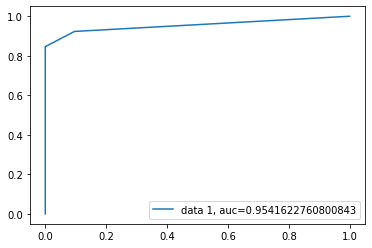

In [9]:
print("Accuracy : ", accuracy_score(yTest_knn, PredictedOutcome_knn) * 100)
print("This is the classification report\n", classification_report(yTest_knn, PredictedOutcome_knn))
print("This is the confusion matrix\n", confusion_matrix(yTest_knn, PredictedOutcome_knn))

y_predict_prob = knn.predict_proba(xTest_knn)[::, 1]
fpr, tpr, _ = metrics.roc_curve(yTest_knn, y_predict_prob)
auc = metrics.roc_auc_score(yTest_knn, y_predict_prob)
plt.plot(fpr, tpr, label="data 1, auc=" + str(auc))
plt.legend(loc=4)
plt.show()

# ------------------------------------------------------------------------------------------------------

# Logistic regression

# Preprocessing the data
* We first one-hot-encode the listed features as thet are considered categorical features (from location....diff_sys_hos)
* We pop column result from the dataframe, to insert it back again in the last column in the dataframe
* We store dataframe in numpy array and apply to it MinMaxScaler to scale it from 0 to 1 (column age is the only column to be applied in it minmaxscaler as all other columns are one-hot-encoded)

In [10]:
OneHotEncoded = pd.get_dummies(dataFrame, columns=['location', 'country', 'gender',
                                                   'symptom1', 'symptom2', 'symptom3', 'symptom4', 'symptom5',
                                                   'symptom6', 'diff_sym_hos'])
# To make result column the last
result_popped_log = OneHotEncoded.pop('result')

OneHotEncoded.insert(293, 'result', result_popped_log)

# To scale data
Data_log = np.array(OneHotEncoded)
Scaler = MinMaxScaler()
Data_log = Scaler.fit_transform(Data_log)

# Splitting the data
* We split the data 80% training set and 10% validation set and 10% testing set
* We then split each set to x and y. 

   &rarr; X contains all the columns except column result 
   
   &rarr; Y is the column result

In [11]:
Train_set, Remain_set = train_test_split(Data_log, train_size=0.8, random_state=14, shuffle=True)
Test_set, Valid_set = train_test_split(Remain_set, test_size=0.5, random_state=1, shuffle=True)

xTrain = Train_set[:, :293]
yTrain = Train_set[:, 293]

xTest = Test_set[:, :293]
yTest = Test_set[:, 293]

xValid = Valid_set[:, :293]
yValid = Valid_set[:, 293]

# To get best C hyperparameter using for loop

* &rarr; C represents the inverse regularization parameter - A control variable that retains strength modification of Regularization by being inversely positioned to the Lambda regulator, where

   C = 1/λ
   
   The relationship, would be that lowering C - would strengthen the Lambda regulator.
   
   
* In each C in for loop *(we check the values stated in the array)*:

  &rarr; We train the logistic regression classifier with the training set
  
  &rarr; Then we predict the outcome by the validation set
  
  &rarr; Then we calculate the accuracy by recall_score, **as our output specifies whether the patient has Covid-19 or not, so    we are concerned more with the false negatives as it has more risk to specify that a patient has not Covid-19, but actually he   has. So the recall should be high**
  
  &rarr; Finally we choose the best C and print it

In [12]:
c = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
best_c = 0.001
maxAccuracy = 0

for num in c:
    log_reg_T = LogisticRegression(C=num)
    log_reg_T.fit(xTrain, yTrain)
    PredictedOutcome = log_reg_T.predict(xValid)
    newAccuracy = recall_score(yValid, PredictedOutcome)
    if newAccuracy > maxAccuracy:
        maxAccuracy = newAccuracy
        best_c = num
print("The best C is", best_c)
c = best_c

The best C is 1


# Train the data
  &rarr; We train the logistic regression classifier with the training set
  
  &rarr; Then we predict the outcome by the testing set

In [13]:
log_reg = LogisticRegression()
log_reg.fit(xTrain, yTrain)
PredictedOutcome = log_reg.predict(xTest)

# Test the data and show accuracy
  &rarr; We first print the total accuracy by the ready-built function accuracy score
  
  &rarr; Then we print the classification report
  
  &rarr; Then we print the confusion matrix
  
  &rarr; Then we plot the ROC graph and show the auc (area under curve) inside the graph

Accuracy :  98.83720930232558
This is the classification report
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99        80
         1.0       1.00      0.83      0.91         6

    accuracy                           0.99        86
   macro avg       0.99      0.92      0.95        86
weighted avg       0.99      0.99      0.99        86

This is the confusion matrix
 [[80  0]
 [ 1  5]]


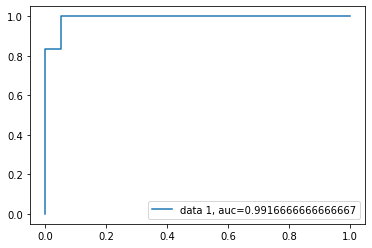

In [14]:
print("Accuracy : ", accuracy_score(yTest, PredictedOutcome) * 100)
print("This is the classification report\n", classification_report(yTest, PredictedOutcome))
print("This is the confusion matrix\n", confusion_matrix(yTest, PredictedOutcome))

y_predict_prob = log_reg.predict_proba(xTest)[::, 1]
fpr, tpr, _ = metrics.roc_curve(yTest, y_predict_prob)
auc = metrics.roc_auc_score(yTest, y_predict_prob)
plt.plot(fpr, tpr, label="data 1, auc=" + str(auc))
plt.legend(loc=4)
plt.show()

# ----------------------------------------------------------------------------------------------------

# Gaussian naive baise

# Preprocessing the data
* We first one-hot-encode the listed features as thet are considered categorical features (from location....diff_sys_hos)
* We pop column result from the dataframe, to insert it back again in the last column in the dataframe
* We pop column age from the dataframe, then we multiply each element by 150, as the result rely much on it, then insert it back
* We store dataframe in numpy array

In [15]:
OneHotEncoded = pd.get_dummies(dataFrame, columns=['location','country','gender',
                                                   'symptom1', 'symptom2', 'symptom3', 'symptom4', 'symptom5',
                                                   'symptom6', 'diff_sym_hos'])
# To make result column the last
result_popped = OneHotEncoded.pop('result')
result_popped2 = OneHotEncoded.pop('age')

result_popped2 = result_popped2*150
OneHotEncoded.insert(1, 'age', result_popped2)
OneHotEncoded.insert(293, 'result', result_popped)

Data = np.array(OneHotEncoded)

# Splitting the data
* We split the data 80% training set and 10% validation set and 10% testing set
* We then split each set to x and y. 

   &rarr; X contains all the columns except column result 
   
   &rarr; Y is the column result

In [16]:
Train_set, Remain_set = train_test_split(Data, train_size=0.8, random_state=97, shuffle=True)
Test_set, Valid_set = train_test_split(Remain_set, test_size=0.5, random_state=97, shuffle=True)

xTrain = Train_set[:, :293]
yTrain = Train_set[:, 293]

xTest = Test_set[:, :293]
yTest = Test_set[:, 293]

xValid = Valid_set[:, :293]
yValid = Valid_set[:, 293]

# To get best var_smoothing hyperparameter using for loop 
* &rarr; Var_smoothing (Variance smoothing) hyperparameter specifies the portion of the largest variance of all features to be added to variances for stability of calculation.
   
   
* In each smoothie in for loop *(we check the values stated in the array)*:

  &rarr; We train the Gaissuan Naive Bayes classifier with the training set
  
  &rarr; Then we predict the outcome by the validation set
  
  &rarr; Then we calculate the accuracy by recall_score, **as our output specifies whether the patient has Covid-19 or not, so    we are concerned more with the false negatives as it has more risk to specify that a patient has not Covid-19, but actually he   has. So the recall should be high**
  
  &rarr; Finally we choose the best var_smoothing and print it

In [17]:
smoothie = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
best_smoothie = 1e-12
maxAccuracy = 0
for num in smoothie:
    gnb_T = GaussianNB(var_smoothing=num)
    gnb_T.fit(xTrain, yTrain)
    PredictedOutcome = gnb_T.predict(xTest)
    newAccuracy = recall_score(yTest, PredictedOutcome) + precision_score(yTest, PredictedOutcome)
    if newAccuracy > maxAccuracy:
        maxAccuracy = newAccuracy
        best_smoothie = num
        
print("The best smoothie is", best_smoothie)
smoothie = best_smoothie

The best smoothie is 1e-07


# Train the data
  &rarr; We train the gaussian naive baise classifier with the training set
  
  &rarr; Then we predict the outcome by the testing set

In [18]:
gnb = GaussianNB(var_smoothing=smoothie)
gnb.fit(xTrain, yTrain)
PredictedOutcome = gnb.predict(xTest)

# Test the data and show accuracy
  &rarr; We first print the total accuracy by the ready-built function accuracy score
  
  &rarr; Then we print the classification report
  
  &rarr; Then we print the confusion matrix
  
  &rarr; Then we plot the ROC graph and show the auc (area under curve) inside the graph

Accuracy :  97.67441860465115
This is the classification report
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.99        76
         1.0       1.00      0.80      0.89        10

    accuracy                           0.98        86
   macro avg       0.99      0.90      0.94        86
weighted avg       0.98      0.98      0.98        86

This is the confusion matrix
 [[76  0]
 [ 2  8]]


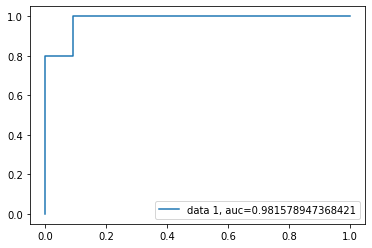

In [19]:
print("Accuracy : ", accuracy_score(yTest, PredictedOutcome) * 100)
print("This is the classification report\n", classification_report(yTest, PredictedOutcome))
print("This is the confusion matrix\n", confusion_matrix(yTest, PredictedOutcome))

y_predict_prob = gnb.predict_proba(xTest)[::, 1]
fpr, tpr, _ = metrics.roc_curve(yTest, y_predict_prob)
auc = metrics.roc_auc_score(yTest, y_predict_prob)
plt.plot(fpr, tpr, label="data 1, auc=" + str(auc))
plt.legend(loc=4)
plt.show()